In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np

#### Ensure that you have the same tf and tfds version as below or else it might not work

In [2]:
tf.__version__,tfds.__version__

('2.4.1', '4.2.0')

#### Need to download gs://cbis-ddsm-tf/curated_breast_imaging_ddsm into ~/tensorflow_datasets/ so that the path is ~/tensorflow_datasets/curated_breast_imaging_ddsm

Requires you to download the source data manually into download_config.manual_dir (defaults to ~/tensorflow_datasets/downloads/manual/):

In [3]:
(ds_train,ds_test,ds_valid),info = tfds.load('curated_breast_imaging_ddsm/patches', split=['train','test','validation'], shuffle_files=True,
              with_info=True)

In [4]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(1))  # Human readable
print(info.features.shape)
print(info.features.dtype)

5
['BACKGROUND', 'BENIGN_CALCIFICATION', 'BENIGN_MASS', 'MALIGNANT_CALCIFICATION', 'MALIGNANT_MASS']
BENIGN_CALCIFICATION
{'id': (), 'image': (None, None, 1), 'label': ()}
{'id': tf.string, 'image': tf.uint8, 'label': tf.int64}


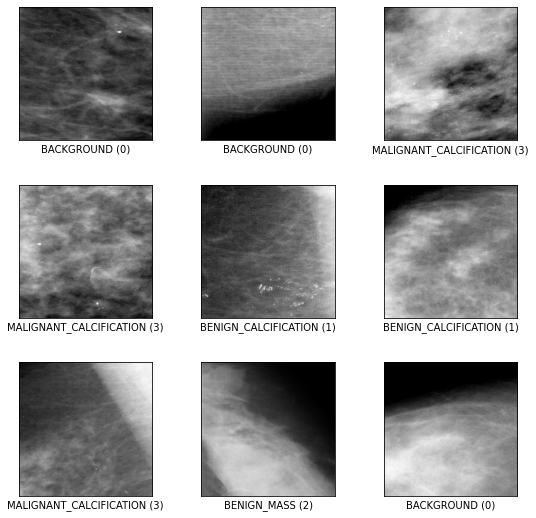

In [7]:
fig = tfds.show_examples(ds_train, info)

Prepare train_dataset to feed into a NN model

In [18]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (224, 224))
    input_image = tf.image.grayscale_to_rgb(input_image) # if using pretrained models
    input_image = normalization_layer(input_image)
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
    datapoint['image'] = input_image
    return datapoint['image'],datapoint['label']

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (224, 224))
    input_image = tf.image.grayscale_to_rgb(input_image) # if using pretrained models
    input_image = normalization_layer(input_image)
    datapoint['image'] = input_image
    return datapoint['image'],datapoint['label']

In [19]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 100
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 10 #TRAIN_LENGTH // BATCH_SIZE

In [20]:
train_dataset = ds_train.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
valid_dataset = ds_valid.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(BATCH_SIZE).cache()
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
for im,lab in train_dataset.take(1):
    break

### Train a model

In [22]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

num_classes = 5

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [24]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])
        self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

In [25]:
history = model.fit(train_dataset, 
                    epochs=1, 
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data = valid_dataset,
                    callbacks=[batch_stats_callback])

 1/10 [==>...........................] - ETA: 2:26 - loss: 1.7487 - sparse_categorical_accuracy: 0.2000

KeyError: 'acc'